
Accuracy: 0.9032692307692308

Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.70      0.71       390
           1       0.91      0.97      0.94      3539
           2       0.96      0.78      0.86      1271

    accuracy                           0.90      5200
   macro avg       0.86      0.82      0.84      5200
weighted avg       0.91      0.90      0.90      5200



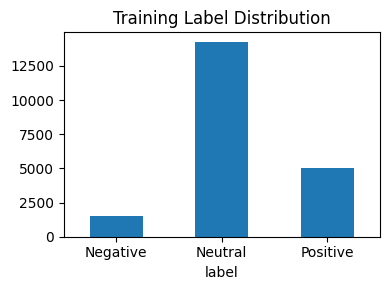

In [ ]:
# ------------------ IMPORTS ------------------
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import re
import matplotlib.pyplot as plt

# ------------------ LOAD DATA ------------------
df = pd.read_csv("stock_news.csv")
df = df[["headline"]].dropna().reset_index(drop=True)


# ------------------ LEXICONS ------------------
positive_words = [
    "gain","gains","gained","rally","rallies","rallied","growth","growing","rise","rises","rising",
    "soar","soars","soared","surge","surges","surged","jump","jumps","jumped","spike","spikes","spiked",
    "increase","increases","increased","higher","strength","strengthen","strengthened",
    "record","record-high","record breaking","all time high","beat","beats","beating","topped","tops",
    "exceed","exceeds","exceeded","outperform","outperforms","outperformed","above expectations",
    "profit","profits","profitable","margin expansion","raised forecast","upgrade","upgraded","improved",
    "recovery","rebound","bounce back","bullish","optimistic","resilient","solid","robust","momentum",
    "expands","expanding","expansion","success","secured","partnership","acquires","launch","launched",
    "innovation","breakthrough","best","better","stronger","positive","boost","boosted","skyrocket","skyrockets","skyrocketed",
    "crush","crushes","crushed","triple","quadruple","double","doubles","doubled","highs","upside","uphit"
]

negative_words = [
    "loss","losses","losing","drop","drops","dropped","decline","declines","declined",
    "fall","falls","fell","selloff","sell-off","plunge","plunges","plunged","tumble","tumbles","tumbled",
    "slump","slumps","slumped","weak","weaker","weakness","downturn","slowdown","cooling demand",
    "missed expectations","miss","misses","missed","earnings miss","cuts forecast","cut forecast",
    "lower guidance","warn","warns","warning","profit slump","loss widening","margin compression",
    "downgrade","downgrades","downgraded","layoff","layoffs","job cuts","fired","recall","recalled",
    "bankrupt","bankruptcy","collapse","collapsed","probe","investigation","lawsuit","sued","sue","sues",
    "fraud","fraudulent","data breach","breach","fine","fined","penalty","risk","risks","uncertainty",
    "volatility","sell pressure","pullback","shortage","shortfall","delays","disruption","spooked"
]

neutral_words = [
    "news","update","report","reports","statement","statements","announces","announce","announcement",
    "says","said","according","reveals","revealed","shows","show","coverage","story","details","highlights",
    "press release","media","article","interview","note","notes","expected","scheduled","meeting","conference"
]


# ------------------ CLEANING FUNCTIONS ------------------
_url_pat = re.compile(r"http\S+|www\.\S+")
_nonalpha_pat = re.compile(r"[^a-z\s]")
_multispace_pat = re.compile(r"\s+")

def clean_text_basic(s: str) -> str:
    s = str(s).lower()
    s = _url_pat.sub(" ", s)
    s = _nonalpha_pat.sub(" ", s)
    s = _multispace_pat.sub(" ", s).strip()
    return s


# ------------------ LABEL CREATION ------------------
def create_label(text: str) -> int:
    t = text.lower()
    for w in positive_words:
        if w in t:
            return 2            # Positive
    for w in negative_words:
        if w in t:
            return 0            # Negative
    for w in neutral_words:
        if w in t:
            return 1            # Neutral
    return 1                    # Default Neutral


# ------------------ TRAIN / TEST SPLIT ------------------
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)

train_df["clean"] = train_df["headline"].apply(clean_text_basic)
test_df["clean"]  = test_df["headline"].apply(clean_text_basic)

train_df["label"] = train_df["clean"].apply(create_label)
test_df["label"]  = test_df["clean"].apply(create_label)


# ------------------ TF-IDF VECTORIZATION ------------------
vectorizer = TfidfVectorizer(max_features=20000, ngram_range=(1,2), min_df=2)
X_train = vectorizer.fit_transform(train_df["clean"])
X_test  = vectorizer.transform(test_df["clean"])
y_train = train_df["label"]
y_test  = test_df["label"]


# ------------------ RANDOM FOREST MODEL ------------------
model = RandomForestClassifier(
    n_estimators=300,
    max_depth=20,
    class_weight="balanced",
    n_jobs=-1,
    random_state=42
)
model.fit(X_train, y_train)


# ------------------ EVALUATION ------------------
preds = model.predict(X_test)

print("\nAccuracy:", accuracy_score(y_test, preds))
print("\nClassification Report:\n", classification_report(y_test, preds))


train_df.head()



# ------------------ LABEL DISTRIBUTION GRAPH ------------------
plt.figure(figsize=(4,3))
train_df["label"].value_counts().sort_index().plot(kind="bar")
plt.xticks([0,1,2], ["Negative", "Neutral", "Positive"], rotation=0)
plt.title("Training Label Distribution")
plt.tight_layout()
plt.show()

In [2]:
train_df.head()


,headline,clean,label
24254,Suze Orman's advice on buying a house right now,suze orman s advice on buying a house right now,1
19453,10 Stocks Getting Hammered on Friday,stocks getting hammered on friday,1
25144,AES Ohio joins National Electric Highway Coali...,aes ohio joins national electric highway coali...,1
25642,Reasons to Retain Intuitive Surgical (ISRG) St...,reasons to retain intuitive surgical isrg stoc...,1
20233,ON BlackRock Advantage Large Cap Value Portfol...,on blackrock advantage large cap value portfol...,1


In [3]:
test_df.head()

,headline,clean,label
4148,Applied Materials Gives Weak Forecast as Short...,applied materials gives weak forecast as short...,0
7841,Rockwell Automation (ROK) Q2 Earnings & Sales ...,rockwell automation rok q earnings sales miss ...,0
18898,CSX (CSX) Stock Sinks As Market Gains: What Yo...,csx csx stock sinks as market gains what you s...,2
4194,5 Things About Take Two Interactive Smart Inve...,things about take two interactive smart invest...,1
8409,Pacific Coast Building Products buys $13 milli...,pacific coast building products buys million r...,1


In [4]:
%pip install yfinance

Note: you may need to restart the kernel to use updated packages.


In [5]:
%pip install feedparser

Note: you may need to restart the kernel to use updated packages.


In [15]:
import yfinance as yf
import pandas as pd
import re
import feedparser
from datetime import datetime, timedelta

# ----------------------------------------------------
# CLEANING
# ----------------------------------------------------
_url_pat = re.compile(r"http\S+|www\.\S+")
_nonalpha_pat = re.compile(r"[^a-z\s]")
_multispace_pat = re.compile(r"\s+")

def clean_text_basic(s):
    s = s.lower()
    s = _url_pat.sub(" ", s)
    s = _nonalpha_pat.sub(" ", s)
    s = _multispace_pat.sub(" ", s).strip()
    return s


# ----------------------------------------------------
# FETCH YAHOO NEWS (SKIP MISSING DATES)
# ----------------------------------------------------
def fetch_yahoo_news(ticker):
    try:
        stock = yf.Ticker(ticker)
        raw = stock.news

        data = []
        for item in raw:
            title = item.get("title", "")

            ts = item.get("providerPublishTime")  # UNIX timestamp
            if not ts:
                continue   # SKIP missing timestamps

            dt = datetime.utcfromtimestamp(ts)
            date = dt.strftime("%Y-%m-%d")
            time = dt.strftime("%H:%M:%S")

            data.append({"headline": title, "date": date, "time": time})

        return data

    except Exception:
        return []


# ----------------------------------------------------
# FETCH GOOGLE NEWS (SKIP MISSING DATES)
# ----------------------------------------------------
def fetch_google_news(company):
    url = f"https://news.google.com/rss/search?q={company}+stock"
    feed = feedparser.parse(url)

    data = []
    for entry in feed.entries:
        title = entry.title

        # RSS date
        if not hasattr(entry, "published_parsed") or entry.published_parsed is None:
            continue  # skip missing timestamp

        dt = datetime(*entry.published_parsed[:6])
        date = dt.strftime("%Y-%m-%d")
        time = dt.strftime("%H:%M:%S")

        data.append({"headline": title, "date": date, "time": time})

    return data


# ----------------------------------------------------
# GET NEWS (NEVER EMPTY)
# ----------------------------------------------------
def get_news(company):
    headlines = fetch_yahoo_news(company)

    if len(headlines) == 0:
        print("⚠ Yahoo returned 0 usable (dated) news — using Google Finance RSS.")
        headlines = fetch_google_news(company)

    if len(headlines) == 0:
        print("❌ No valid dated news from ANY source.")
        return pd.DataFrame({"headline": [], "date": [], "time": []})

    return pd.DataFrame(headlines)


# ----------------------------------------------------
# SENTIMENT + CONFIDENCE + TODAY / LAST 7 DAYS
# ----------------------------------------------------
def test_model_live(company):
    df = get_news(company)

    if len(df) == 0:
        print("No news available — cannot run prediction.")
        return None

    # CLEAN TEXT
    df["clean"] = df["headline"].apply(clean_text_basic)

    # TRANSFORM
    X = vectorizer.transform(df["clean"])

    # PREDICT + CONFIDENCE
    df["prediction"] = model.predict(X)
    df["confidence"] = model.predict_proba(X).max(axis=1).round(3)

    sentiment_map = {0: "Bearish", 1: "Neutral", 2: "Bullish"}
    df["sentiment"] = df["prediction"].map(sentiment_map)

    # FILTER TODAY
    today = datetime.utcnow().strftime("%Y-%m-%d")
    df_today = df[df["date"] == today]

    if len(df_today) == 0:
        print("⚠ No news released TODAY.")
        print("📅 Showing last 7 days instead.\n")

        seven_days_ago = datetime.utcnow() - timedelta(days=7)
        df["date_dt"] = pd.to_datetime(df["date"])

        df_7 = df[df["date_dt"] >= seven_days_ago]

        df_7 = df_7.drop(columns=["date_dt"])
        print(df_7[["date", "time", "headline", "sentiment", "confidence"]])

        df_7.to_csv(f"{company}_recent_news.csv", index=False)
        print(f"\nSaved: {company}_recent_news.csv\n")
        return df_7

    # OTHERWISE PRINT TODAY'S DATA
    print("\n===== TODAY'S NEWS SENTIMENT =====\n")
    print(df_today[["date", "time", "headline", "sentiment", "confidence"]])

    df_today.to_csv(f"{company}_today_news.csv", index=False)
    print(f"\nSaved: {company}_today_news.csv\n")

    return df_today


# ----------------------------------------------------
# RUN
# ----------------------------------------------------
test_model_live("HIKAL")

⚠ Yahoo returned 0 usable (dated) news — using Google Finance RSS.

===== TODAY'S NEWS SENTIMENT =====

         date      time                                           headline  \
0  2025-12-03  04:16:06  Hikal Hits Intraday High with Strong 7.96% Sur...   
1  2025-12-03  04:25:00  HIKAL CHEMIC Share Price Today Up 11% - Equity...   
2  2025-12-03  06:45:00  Vivid Mercantile Ltd leads gainers in 'B' grou...   
3  2025-12-03  04:03:01  Hikal Stock Analysis: Technical Momentum Shift...   
7  2025-12-03  08:43:19  Hikal Sees Exceptional Trading Volume Amidst W...   
9  2025-12-03  07:43:13  Hikal Ltd Sees Significant Trading Activity Am...   

  sentiment  confidence  
0   Bullish       0.344  
1   Neutral       0.363  
2   Neutral       0.367  
3   Bullish       0.398  
7   Neutral       0.362  
9   Neutral       0.364  

Saved: HIKAL_today_news.csv



/var/folders/vp/yclq30d91h31xrq8sxfgx2ph0000gn/T/ipykernel_10765/747334332.py:115: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  today = datetime.utcnow().strftime("%Y-%m-%d")


,headline,date,time,clean,prediction,confidence,sentiment
0,Hikal Hits Intraday High with Strong 7.96% Sur...,2025-12-03,04:16:06,hikal hits intraday high with strong surge ami...,2,0.344,Bullish
1,HIKAL CHEMIC Share Price Today Up 11% - Equity...,2025-12-03,04:25:00,hikal chemic share price today up equitymaster,1,0.363,Neutral
2,Vivid Mercantile Ltd leads gainers in 'B' grou...,2025-12-03,06:45:00,vivid mercantile ltd leads gainers in b group ...,1,0.367,Neutral
3,Hikal Stock Analysis: Technical Momentum Shift...,2025-12-03,04:03:01,hikal stock analysis technical momentum shifts...,2,0.398,Bullish
7,Hikal Sees Exceptional Trading Volume Amidst W...,2025-12-03,08:43:19,hikal sees exceptional trading volume amidst w...,1,0.362,Neutral
9,Hikal Ltd Sees Significant Trading Activity Am...,2025-12-03,07:43:13,hikal ltd sees significant trading activity am...,1,0.364,Neutral
